Данные взяты с https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=stores.csv

## Цель работы

Изучить данные по продажам продуктов, продаваемых в магазинах Favorita, расположенных в Эквадоре. Частично визуализировать данные и с помощью этого увидеть какие-то зависимости и изменения. 

Данные включают даты, информацию о магазине и продукте, информацию о том, рекламировался ли этот товар, а также количество продаж.

In [177]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
%matplotlib inline
sns.set(rc = {'figure.figsize': (15,10)})

import warnings
warnings.filterwarnings('ignore')

In [178]:
holidays_events = pd.read_csv(r'holidays_events.csv', encoding = 'utf-8')
oil = pd.read_csv(r'oil.csv', encoding = 'utf-8')
sample_submission = pd.read_csv(r'sample_submission.csv', encoding = 'utf-8')
stores = pd.read_csv(r'stores.csv', encoding = 'utf-8')
test = pd.read_csv(r'test.csv', encoding = 'utf-8')
train = pd.read_csv(r'train.csv', encoding = 'utf-8')
transactions = pd.read_csv(r'transactions.csv', encoding = 'utf-8')

In [179]:
dfs = [holidays_events, oil, sample_submission, stores, test, train, transactions]

In [180]:
print('holidays_events\n')
print(holidays_events.isna().sum())
print('---------------------------------')

print('oil\n')
print(oil.isna().sum())
print('---------------------------------')

print('sample_submission\n')
print(sample_submission.isna().sum())
print('---------------------------------')

print('stores\n')
print(stores.isna().sum())
print('---------------------------------')

print('test\n')
print(test.isna().sum())
print('---------------------------------')

print('train\n')
print(train.isna().sum())
print('---------------------------------')

print('transactions\n')
print(transactions.isna().sum())
print('---------------------------------')

holidays_events

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
---------------------------------
oil

date           0
dcoilwtico    43
dtype: int64
---------------------------------
sample_submission

id       0
sales    0
dtype: int64
---------------------------------
stores

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
---------------------------------
test

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
---------------------------------
train

Unnamed: 0     0
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
---------------------------------
transactions

date            0
store_nbr       0
transactions    0
dtype: int64
---------------------------------


В таблице oil есть 43 пропущенных значения. Важно помнить об этом в дальнейшем

## Описание таблиц

In [181]:
start = train['date'].min()
finish = train['date'].max()
print(f'Тут представленны данные в промежуток с {start} по {finish}')

#Данные по продажам за 4.5 года

Тут представленны данные в промежуток с 2013-01-01 по 2015-12-31


### sample_submission 
Нужен чисто для того, чтобы показать правильный формат вывода данных при обучении модели


In [182]:
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


### holidays_events - Это датафрейм с датами праздников, празднование которых, возможно, переносилось

In [183]:
holidays_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [184]:
holidays_events[holidays_events['date'] == '2012-03-02']

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [185]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'], format="%Y-%m-%d")

In [186]:
holidays_events['date'].dt.to_period('Y')

0      2012
1      2012
2      2012
3      2012
4      2012
       ... 
345    2017
346    2017
347    2017
348    2017
349    2017
Name: date, Length: 350, dtype: period[A-DEC]

In [187]:
holidays_events['months'] = holidays_events['date'].dt.to_period('M')
holidays_events['years'] = holidays_events['date'].dt.to_period('Y')

In [188]:
holidays_events.value_counts('type')

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
dtype: int64

In [189]:
holidays_events.value_counts('locale')

locale
National    174
Local       152
Regional     24
dtype: int64

In [190]:
holidays_events.value_counts('locale_name')

locale_name
Ecuador                           174
Quito                              13
Ambato                             12
Guaranda                           12
Riobamba                           12
Latacunga                          12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Manta                               6
Santo Domingo                       6
Santa Elena                         6
Salinas                             6
Quevedo                             6
Puyo                                6
Libertad                            6
Machala                             6
Loja                                6
Cayambe                             6
Imbabura                            6
Esmeraldas                          6
El Carmen                           6
Cotopaxi                            6
Santo Domingo de los Tsachilas      6
dtype: int64

In [191]:
holidays_events.value_counts('description')

description
Carnaval                                 10
Fundacion de Cuenca                       7
Fundacion de Ibarra                       7
Navidad+1                                 6
Navidad                                   6
                                         ..
Terremoto Manabi+14                       1
Terremoto Manabi+16                       1
Terremoto Manabi+17                       1
Inauguracion Mundial de futbol Brasil     1
Terremoto Manabi+15                       1
Length: 103, dtype: int64

In [192]:
holidays_events.value_counts('transferred')

transferred
False    338
True      12
dtype: int64

date - дата

type - тип праздника

locale - масштаб

locale_name - место проведения праздника

description - название праздника

transferred - перенесло ли правительство праздник или нет

## oil - цена на нефть
(Эквадор очень зависящая от нефти страна - написано в описании к данным)

In [193]:
print(f'Пропущенных значений: \n{oil.isnull().sum()} \n\nВсего значений \n{oil.count()}')
#Лучше будет сразу удалить те значения, где курс на нефть не вписан

Пропущенных значений: 
date           0
dcoilwtico    43
dtype: int64 

Всего значений 
date          1218
dcoilwtico    1175
dtype: int64


In [194]:
oil['date'] = pd.to_datetime(oil['date'], format="")
oil['date'].dt.to_period('D')

0       2013-01-01
1       2013-01-02
2       2013-01-03
3       2013-01-04
4       2013-01-07
           ...    
1213    2017-08-25
1214    2017-08-28
1215    2017-08-29
1216    2017-08-30
1217    2017-08-31
Name: date, Length: 1218, dtype: period[D]

<AxesSubplot:xlabel='date', ylabel='dcoilwtico'>

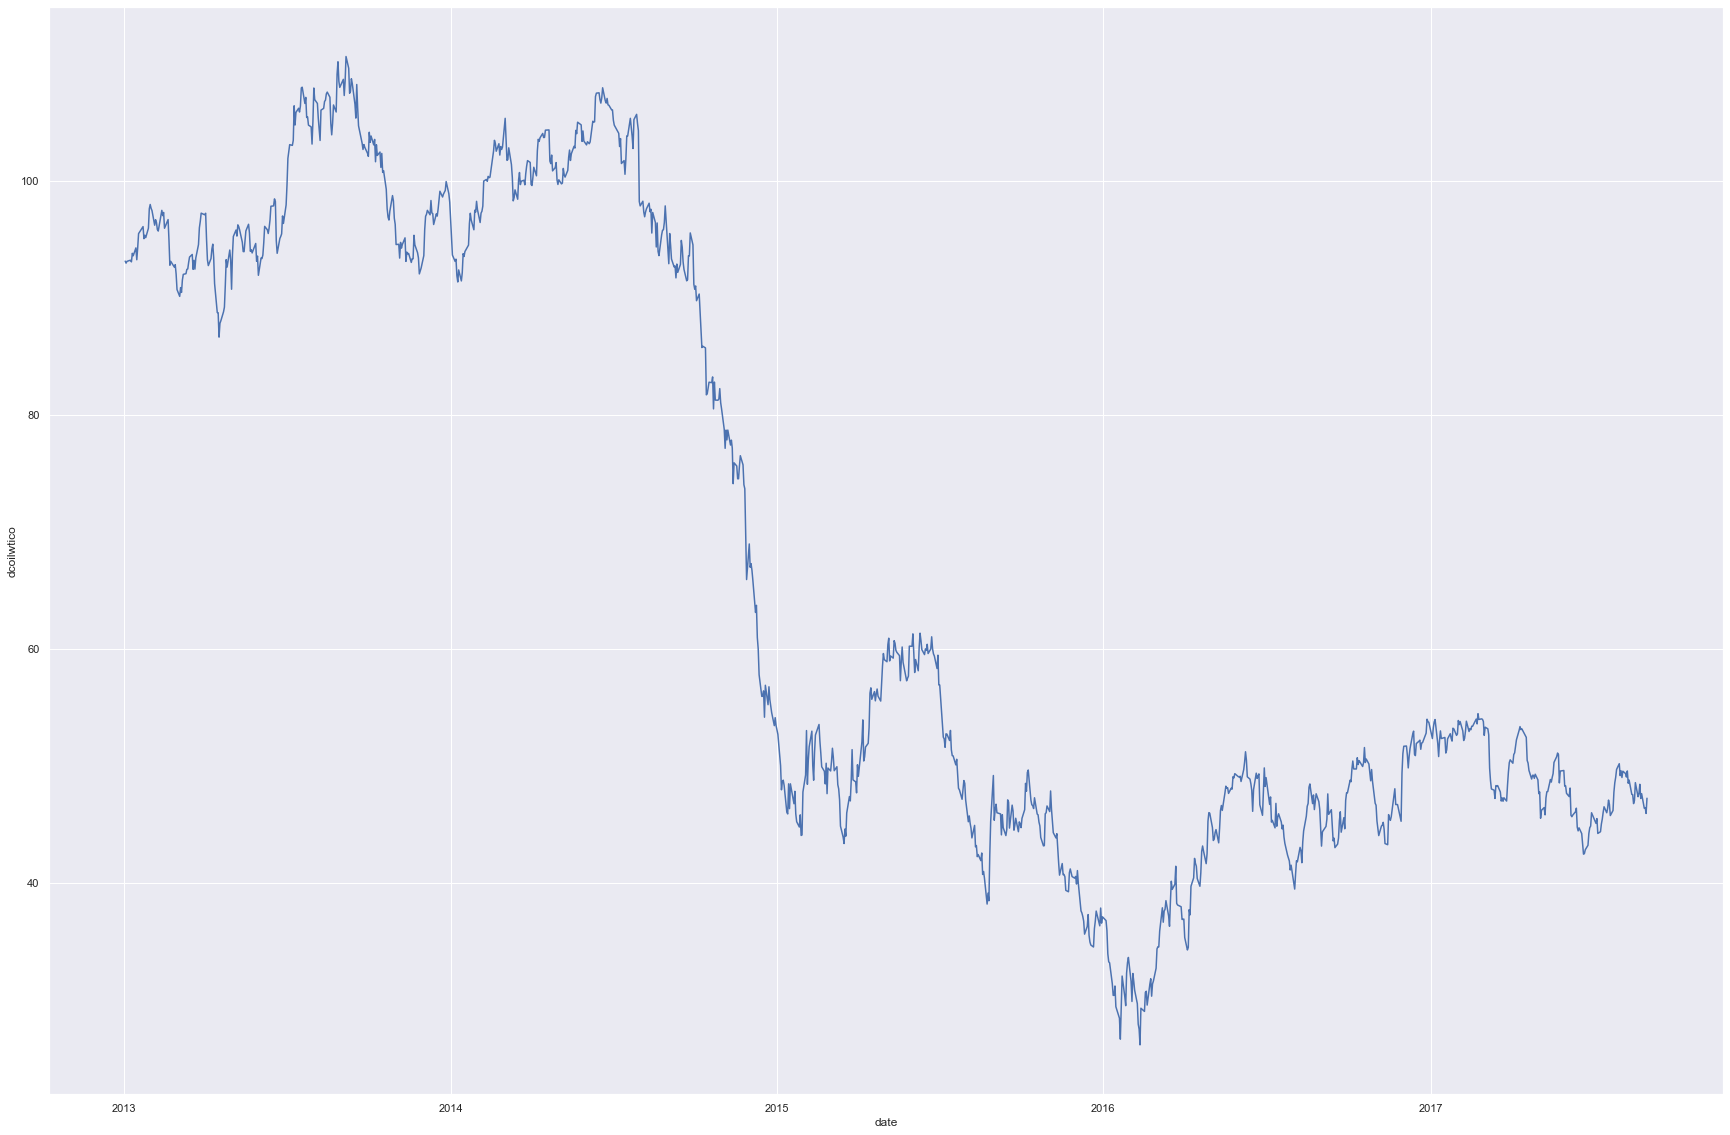

In [195]:
plt.figure(figsize = (30, 20))
sns.lineplot(data = oil, x = 'date', y = 'dcoilwtico')

In [196]:
diff_oil = pd.concat([oil['date'], oil['dcoilwtico'].diff()], axis = 1).rename(columns = {'date':'date_diff_price'})
diff_oil = diff_oil[1:] #удалим новопоявившееся пустое значение

In [197]:
diff_oil.sort_values('dcoilwtico').head(10)
#Отсюда видно, что самые резкие падения цены на нефть были в 2014 и 2015 годах.
#Можно предположить, что это связано с ситуацией, которая была вокруг Крыма
#Так же очень вероятно, что это повлияло на заработок магазина. Изучим это в дальнейшем

,date_diff_price,dcoilwtico
412,2014-07-31,-6.06
546,2015-02-04,-4.59
465,2014-10-14,-4.01
695,2015-09-01,-3.82
591,2015-04-08,-3.51
455,2014-09-30,-3.36
122,2013-06-20,-3.35
841,2016-03-23,-3.17
487,2014-11-13,-3.03
550,2015-02-10,-2.93


### transactions показывает сколько продаж было в какой-то из дней в каждом из магазинов

In [198]:
transactions.store_nbr.nunique()
#54 разных магазина

54

In [199]:
transactions.groupby('store_nbr').agg({'transactions':'sum'}) \
    .sort_values(by = 'transactions', ascending = False) \
    .reset_index().head(3)
#Получили выручку по каждому магазину за всё время
#Изучим динамику изменения выручки на 3 самых "богатых" и 3 самых "бедных" точках

,store_nbr,transactions
0,44,7273093
1,47,6535810
2,45,6201115


Text(0.5, 1.0, 'Сколько зарабатывает каждый магазин, каждый день')

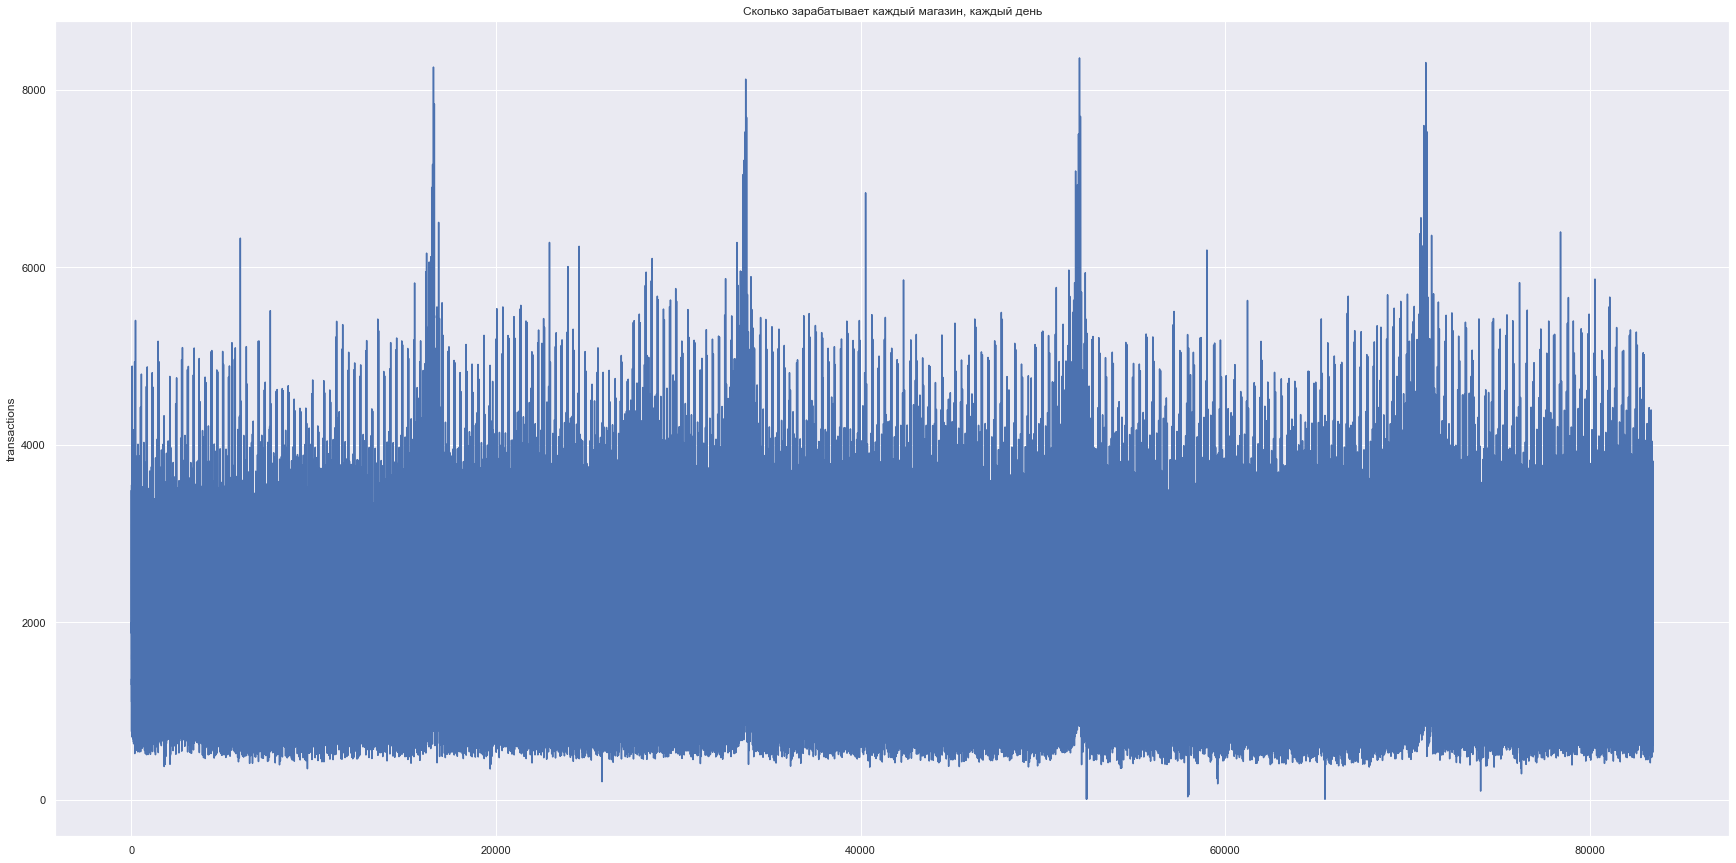

In [200]:
plt.figure(figsize = (30, 15))
sns.lineplot(data = transactions.transactions)
plt.title('Сколько зарабатывает каждый магазин, каждый день')
#График Суммы заработаных денег отличается явными выбросами в большую сторону. Возможно, они связаны с каким-либо праздником

Text(0.5, 1.0, 'Сколько суммарно зарабатывают все магазины каждый день')

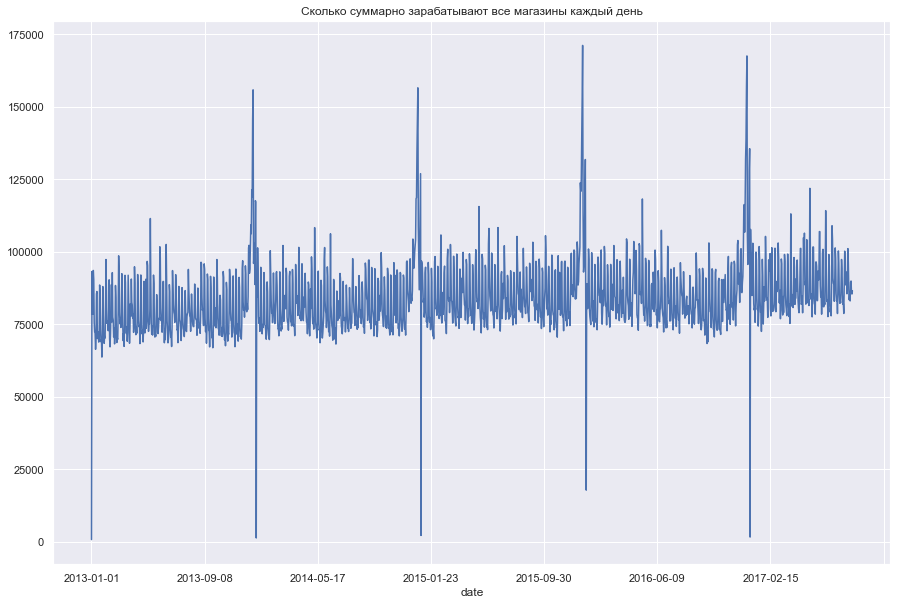

In [201]:
transactions.groupby('date')['transactions'].sum().plot()
#График зарабатка в разные дни всех магазинов суммарно - Для того, чтобы более явно видеть выбросы
#Явно видны выбросы, которые стабильно повторяются через определенные промежутки времени
plt.title('Сколько суммарно зарабатывают все магазины каждый день')

В нашем графике видны выбросы как в бОльшую сторону, так и в меньшую.

Это может быть например связано с:
1) ошибками в данных

2) Заработок за одни даты(начало года) записывают в другие даты(конец прошлого года)

3) Люди ежегодно идут за покупками (напримео, в праздник), а дальше магазин не работает

Посмотрим даты, когда происходят эти выбросы.

In [202]:
transactions.groupby('date')['transactions'].sum().sort_values(ascending = False).quantile(0.99)
#Лишь 1% сумм больше чем 123981

123981.19000000005

In [203]:
transactions.groupby('date')['transactions'].sum().sort_values(ascending = False).quantile(0.01)
#Лишь 1% сумм меньше чем 68368

68368.92

In [204]:
#Изучим даты, когда были самые прибыльные дни
date_sum_price = transactions.groupby('date')['transactions'].sum()

In [205]:
date_sum_price[date_sum_price > 123981].head()
#Самые большие суммы люди тратят в предверии нового года.
# В целом логично, но теперь это ещё и явно видно

date
2013-12-23    145876
2013-12-24    155846
2014-12-22    134574
2014-12-23    144513
2014-12-24    156546
Name: transactions, dtype: int64

In [206]:
date_sum_price[date_sum_price < 68368].sort_values().head()
#А меньше всего, частично, в январе. Возможно, частично это связано с тем, что магазины не работают

date
2013-01-01      770
2014-01-01     1327
2017-01-01     1642
2015-01-01     2202
2016-01-04    17829
Name: transactions, dtype: int64

In [207]:
holidays_events[(holidays_events['months'] == '2013-12') | (holidays_events['months'] == '2014-12') |
               (holidays_events['months'] == '2015-12')].groupby('description')['date'].count().sort_values(ascending = False)

#Судя по результатам очень много покупок совершается в рождество(Navidad). Замечательный праздник, который явно любят в Эквадоре

description
Cantonizacion de Salinas    3
Fundacion de Loja           3
Fundacion de Quito          3
Fundacion de Quito-1        3
Navidad                     3
Navidad+1                   3
Navidad-1                   3
Navidad-2                   3
Navidad-3                   3
Navidad-4                   3
Primer dia del ano-1        3
Cyber Monday                1
Puente Navidad              1
Recupero Puente Navidad     1
Name: date, dtype: int64

--------------------

## Изучим таблицу stores
Информация о магазинах

In [208]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [209]:
stores.shape
#Судя по всему это просто таблица с данными про каждый отдельно взятый магазин - его местоположение, тип и тп

(54, 5)

In [210]:
stores.groupby("state")['store_nbr'].count().sort_values(ascending = False)
#Видно, что больше всего магазинов данной фирмы в штатах Pichincha, Guayas и Azuay

state
Pichincha                         19
Guayas                            11
Azuay                              3
Manabi                             3
Santo Domingo de los Tsachilas     3
Cotopaxi                           2
El Oro                             2
Los Rios                           2
Tungurahua                         2
Bolivar                            1
Chimborazo                         1
Esmeraldas                         1
Imbabura                           1
Loja                               1
Pastaza                            1
Santa Elena                        1
Name: store_nbr, dtype: int64

In [211]:
much_stores = stores[stores['state'] == 'Pichincha']
much_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
5,6,Quito,Pichincha,D,13


In [212]:
train.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion
0,0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,4,2013-01-01,1,BOOKS,0.0,0


In [213]:
train.sales.describe()

count    1.945944e+06
mean     3.035922e+02
std      9.611835e+02
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      1.620000e+02
max      4.627100e+04
Name: sales, dtype: float64

In [214]:
train.onpromotion.describe()

count    1.945944e+06
mean     7.946729e-01
std      6.603357e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.350000e+02
Name: onpromotion, dtype: float64

In [215]:
train["sales"].corr(train["onpromotion"])
#На всякий случай убедимся в том, что есть положительная связь между вложениями в продвижениями и зарабатываемой суммой денег

0.23576496635393263

--------------

### Построим несколько графиков, чтобы понять некоторую информацию про таблицу train

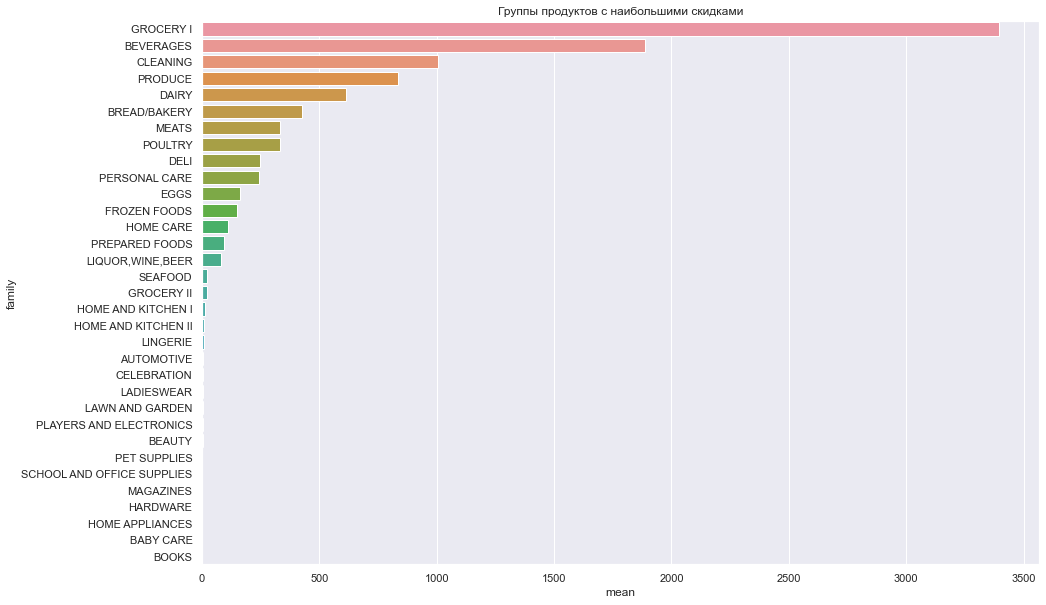

In [216]:
sns.barplot(data = train.groupby('family')['sales'].agg(['mean']).sort_values(by = 'mean', ascending = False).reset_index(), \
           x = 'mean', \
           y = 'family')
plt.title('Группы продуктов с наибольшими скидками')
plt.show()

In [217]:
train['date'] = pd.to_datetime(train['date'], format = "%Y-%m-%d")
transactions['date'] = pd.to_datetime(transactions['date'], format = "%Y-%m-%d")

In [218]:
cols_to_show = train.groupby('family')['sales'].agg(['mean']).sort_values(by = 'mean', ascending = False).reset_index().iloc[0:3, :]

In [219]:
cols_to_show

,family,mean
0,GROCERY I,3395.659659
1,BEVERAGES,1886.687814
2,CLEANING,1007.216558


В качестве практики изучим самые продаваемые товары в магазине номер 5

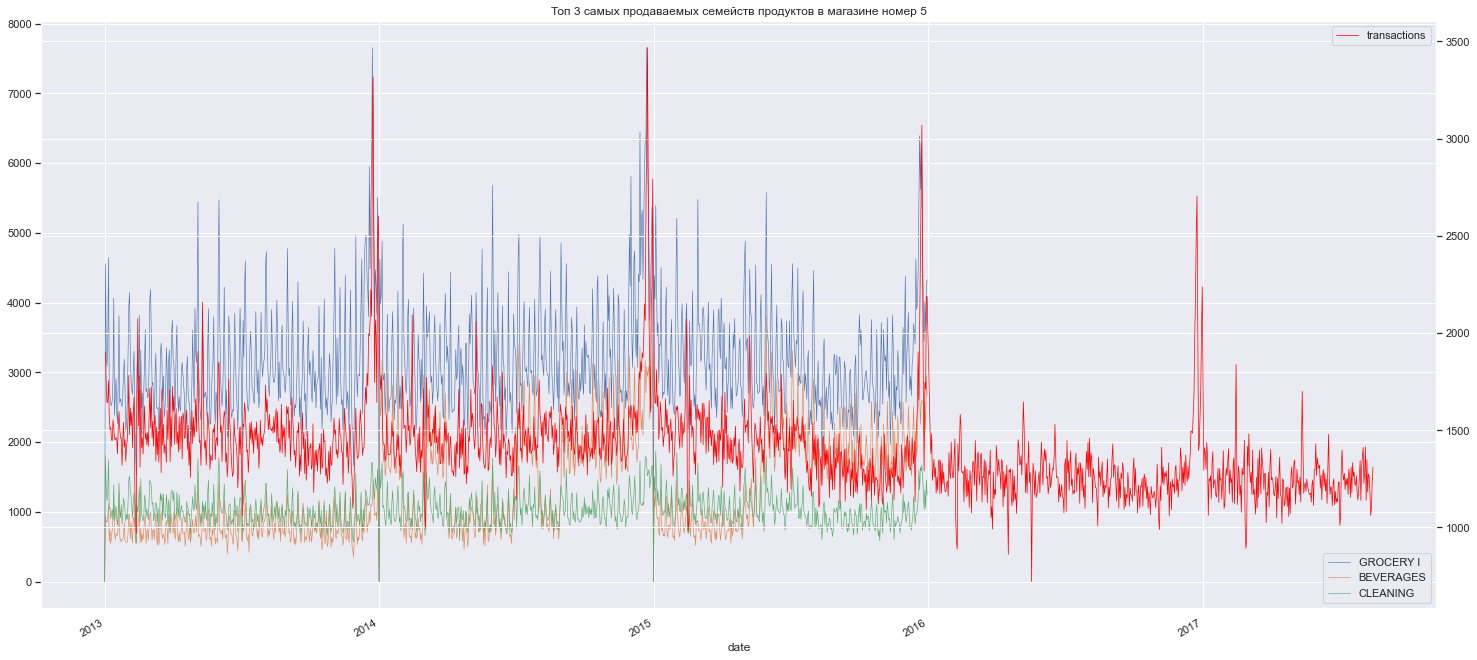

In [220]:
store = 5

fig, ax = plt.subplots(figsize = (25, 12))
for col in cols_to_show['family']:
    plot[col] = train[(train['store_nbr'] == store) & (train['family'] == col)]\
    .reset_index() \
    .plot(ax = ax,
          x = 'date',
          y = 'sales',
          label = col,
          lw = 0.6,
          )

ax2 = ax.twinx()
plot['transactions'] = transactions[transactions['store_nbr'] == store].reset_index()\
            .plot(ax = ax2,
                 x = "date",
                 y = 'transactions',
                 color = 'red',
                 lw = 0.7)
ax.legend(loc = 'lower right')
plt.title(f'Топ {len(cols_to_show)} самых продаваемых семейств продуктов в магазине номер {store}')
plt.show()

# Гипотеза
### Изменился ли как-то средний заработок со временем.
И если заработок уменьшился, связано ли это с курсом нефти?

Возможный способ узнать это наверняка - сравнить средние траты в 2013 и в 2015 году. Конечно, не учитывается инфляция и многие другие факторы - но всё-равно это может помочь сделать какие-то выводы о развитии магазина.

In [221]:
train.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion
0,0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,4,2013-01-01,1,BOOKS,0.0,0


In [222]:
train['date'] = pd.to_datetime(train['date'], format="")
train['year'] = train['date'].dt.to_period('Y')
train['months'] = train['date'].dt.to_period('M')
#перевод даты в нужный формат, и создание колонок год и месяц

In [223]:
high_oil_price = train[train['year'] == '2013'][['date','year', 'months' ,'store_nbr','sales']]
low_oil_price = train[train['year'] == '2015'][['date', 'year', 'months' ,'store_nbr','sales']]

# high_oil_price - данные за 2013 год (высокая цена на нефть)
# low_oil_price - данные за 2015 год (низкая цена на нефть)

In [224]:
high_oil_price = high_oil_price.merge(oil, how='inner', on='date')
low_oil_price = low_oil_price.merge(oil, how='inner', on='date')

<AxesSubplot:xlabel='date', ylabel='sales'>

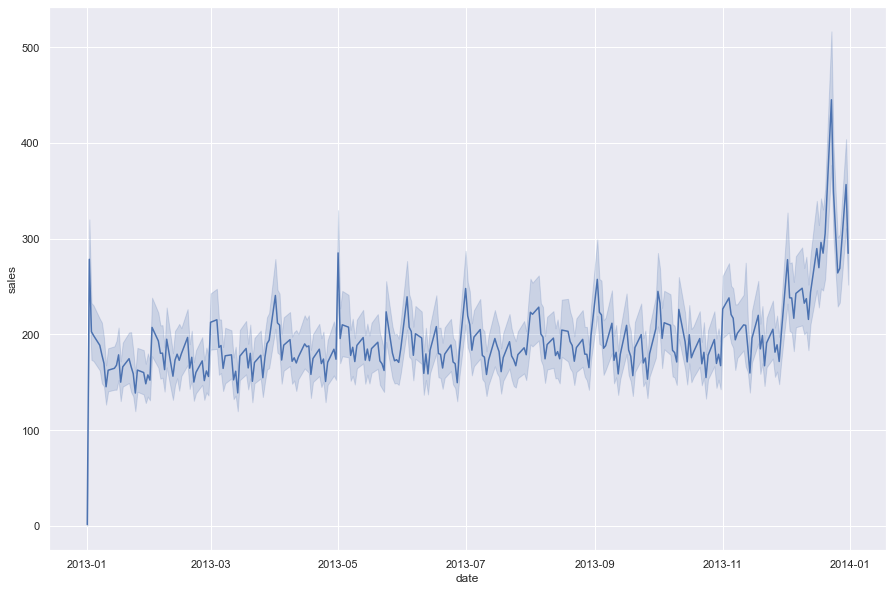

In [225]:
sns.lineplot(data = high_oil_price, x = 'date', y = 'sales')

<AxesSubplot:xlabel='date', ylabel='sales'>

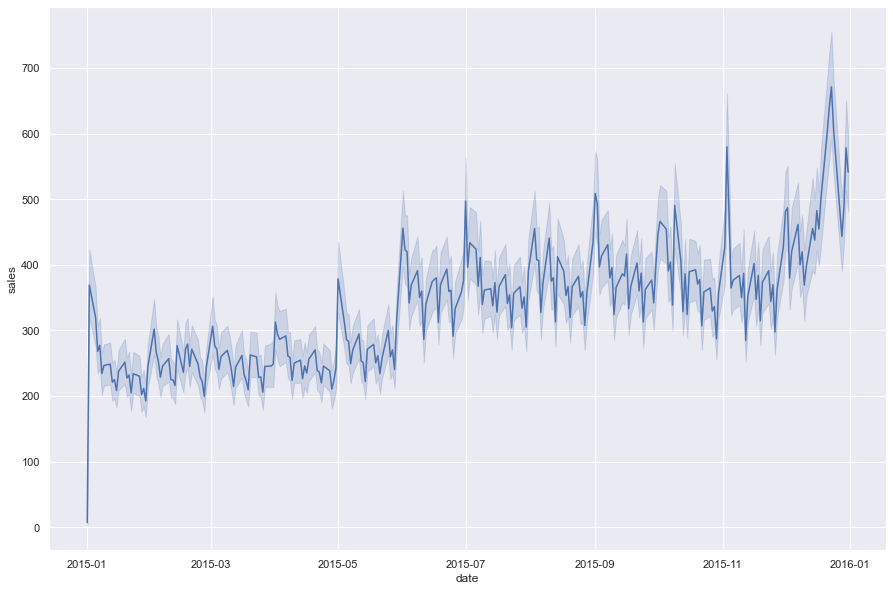

In [226]:
sns.lineplot(data = low_oil_price, x = 'date', y = 'sales')

In [227]:
high_oil_price.groupby(['date']).sum()['sales'].reset_index(name = 'sum_by_day')

,date,sum_by_day
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-07,336122.801066
...,...,...
255,2013-12-24,620663.290732
256,2013-12-26,470731.162414
257,2013-12-27,479314.968043
258,2013-12-30,635134.735851


In [228]:
mean_high = high_oil_price['sales'].mean()
mean_low = low_oil_price['sales'].mean()

std_high = high_oil_price['sales'].std()
std_low = low_oil_price['sales'].std()

print(f'В 2013 году средний заработок был {mean_high} Со стандартным отклонением {std_high}')
print(f'А в 2015 году среднее значение {std_high} И стандартное отклонениее  {std_low}')

В 2013 году средний заработок был 191.67069341109422 Со стандартным отклонением 632.6522647923258
А в 2015 году среднее значение 632.6522647923258 И стандартное отклонениее  963.091084020983


### Перед построением графиков распределений отклонений от среднего, приведем значения к Z статистике

In [229]:
def to_z(value, mean, std):
    return (value - mean)/std

In [230]:
high_oil_price['z_sales'] = high_oil_price['sales'].apply(to_z, mean = mean_high, std = std_high)
low_oil_price['z_sales'] = low_oil_price['sales'].apply(to_z, mean = mean_low, std = std_low)

In [231]:
#sns.barplot(x = high_oil_price.sort_values(by = "sales")['sales'], y = high_oil_price.sort_values(by = "sales")['sales'])

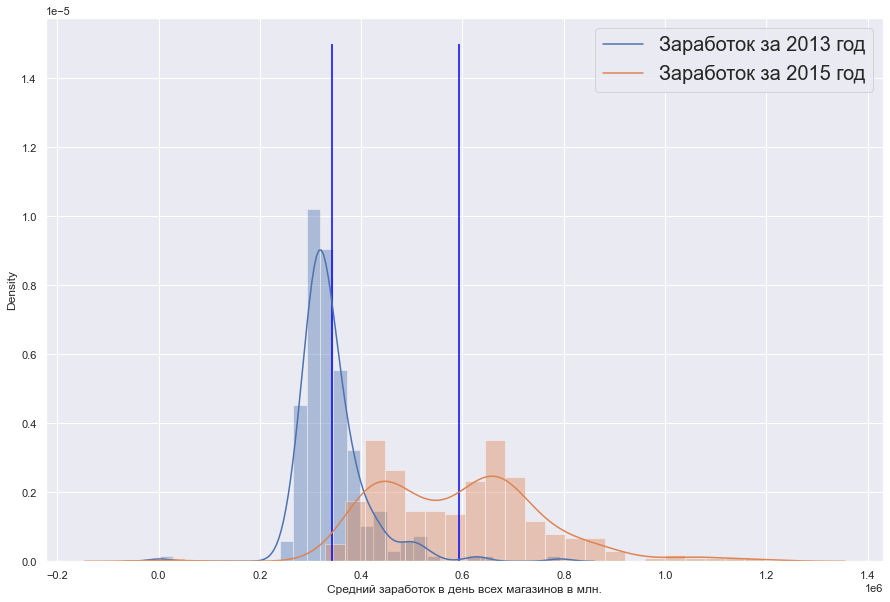

In [232]:
sns.distplot(high_oil_price.groupby('date').sum().sales, bins = 30)
sns.distplot(low_oil_price.groupby('date').sum().sales, bins = 30)
plt.vlines(high_oil_price.groupby('date').sum().sales.mean(), ymin = 0, ymax = 0.000015, color = 'blue')
plt.vlines(low_oil_price.groupby('date').sum().sales.mean(), ymin = 0, ymax = 0.000015, color = 'blue')


plt.xlabel('Средний заработок в день всех магазинов в млн.')
plt.legend(['Заработок за 2013 год', 'Заработок за 2015 год'],  prop={'size': 20})

Очевидно, что Оба графика имеют не нормальное распределение. Но даже без подробного сравнения выборок видно, что продаваемость в 2015 году выше. Если были сомнения использовал бы непараметрические критерии сравнения двух выборок(Мана Уитни или Колмогорова-Смирнова(скорее второй, т.к. количество данных высокое)).

Легко заметить цены в 2015 году имеют бимодальное распределение.
Это может быть связано с тем, что в 2015 году было открыто много новых магазинов. Или же часть магазинов резко стала зарабатывать намного больше/меньше.

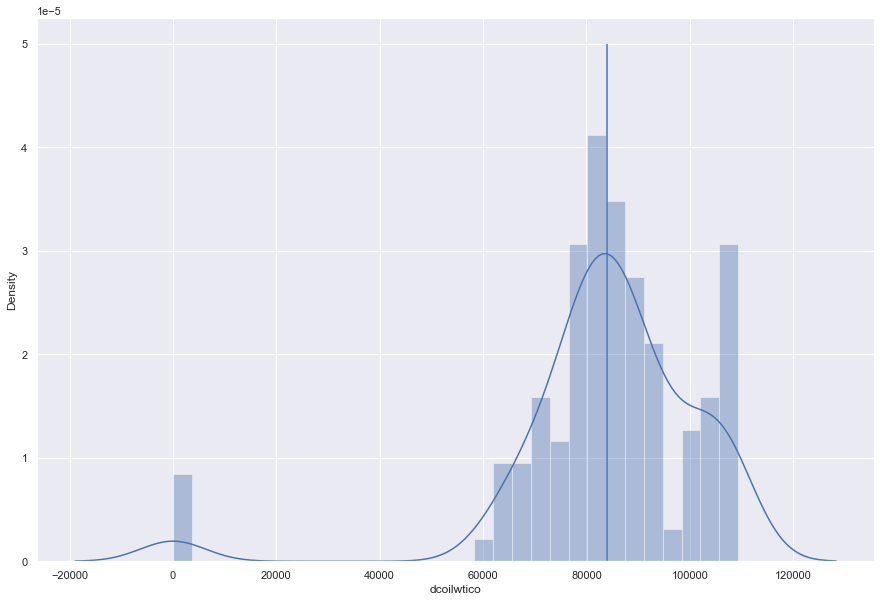

In [233]:
#Так как всё ещё есть вероятность, что мог повлиять курс цены на нефть, можно посмотреть и это распределение
#Оно оказалось так же бимодальным

sns.distplot(low_oil_price.groupby('date').sum().dcoilwtico, bins = 30)
plt.vlines(low_oil_price.groupby('date').sum().dcoilwtico.mean(), ymin = 0, ymax = 0.00005)

In [234]:
low_oil_price['z_dcoilwtico'] = low_oil_price['dcoilwtico'].apply(to_z, \
                                                                   mean = low_oil_price.dcoilwtico.mean(), \
                                                                   std = low_oil_price.dcoilwtico.std())

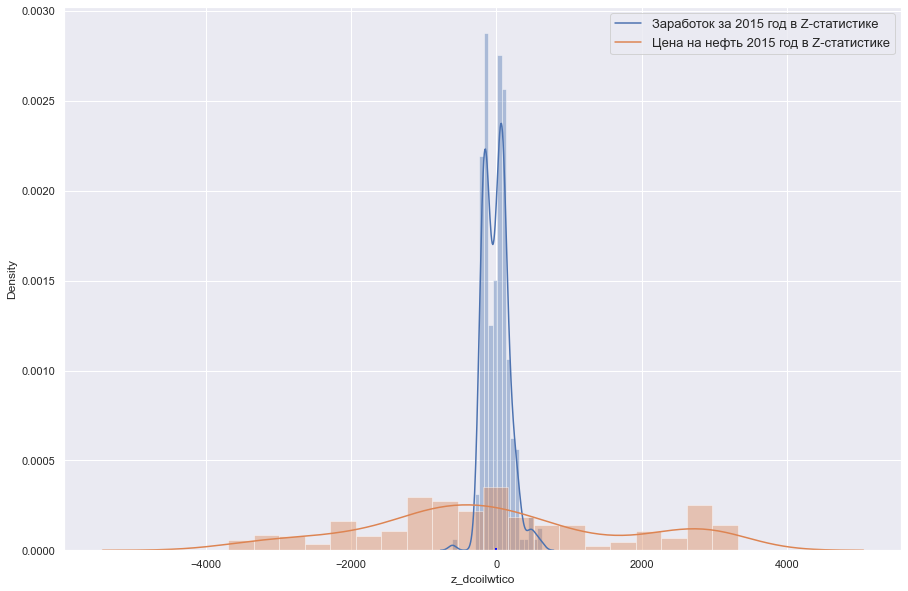

In [235]:
sns.distplot(low_oil_price.groupby('date').sum().z_sales, bins = 20)
sns.distplot(low_oil_price.groupby('date').sum().z_dcoilwtico, bins = 20)
plt.vlines(low_oil_price.groupby('date').sum().z_sales.mean(), ymin = 0, ymax = 0.000015, color = 'blue')
plt.vlines(low_oil_price.groupby('date').sum().z_sales.mean(), ymin = 0, ymax = 0.000015, color = 'blue')


plt.legend(['Заработок за 2015 год в Z-статистике', 'Цена на нефть 2015 год в Z-статистике'],  prop={'size': 13})

In [ ]:
sns.lineplot(data = low_oil_price, x = 'date', y='z_dcoilwtico')
sns.lineplot(data = low_oil_price, x = 'date', y=low_oil_price['z_sales']*5)
        #Умножаем значения, чтобы лучше была видна зависимость на графике


### Судя по графикам зависимостей цены на нефть и продаж в магазинах от даты - дело не в курсе цен на нефть

In [ ]:
low_oil_price = low_oil_price.merge(stores, on = "store_nbr", how = 'left')
#добавим описание каждого магазина в нашу таблицу

In [ ]:
sns.distplot(low_oil_price.loc[low_oil_price.sales < low_oil_price.sales.quantile(0.95)].sales, bins = 50)
#График плотности распределения цен по дням в 2015 году

#График обладает очень большим количеством "очень больших" значений - т.е. длинным хвостом. Даже с учетом 0.95 квантиля

In [ ]:
sns.distplot(np.log(low_oil_price.loc[low_oil_price.sales > 0].sales, dtype='float64'), bins = 50)
plt.xlabel('натуральный логарифм от прибыли')

#После логарифмирования прибыли были "усечены" самые крайние значения => график сжался как гормошка

In [ ]:
a = low_oil_price.loc[low_oil_price.sales > low_oil_price.sales.quantile(0.95)].sales.sum()/low_oil_price.sales.sum()*100
b = low_oil_price.loc[low_oil_price.sales < low_oil_price.sales.quantile(0.95)].sales.sum()/low_oil_price.sales.sum()*100

print(f'На самом деле хвост настолько длинный, что 5% совершённых самых прибыльных покупок приносят {round(a, 2)}% прибыли')
print(f'А остальные 95% покупок приносят лишь {round(b, 2)}% прибыли')

In [ ]:
high_sales = low_oil_price.loc[(low_oil_price.sales > low_oil_price.sales.quantile(0.9)) & 
                               (low_oil_price.sales > 0)]
low_sales = low_oil_price.loc[(low_oil_price.sales < low_oil_price.sales.quantile(0.9)) & 
                             (low_oil_price.sales > 0)]

In [ ]:
sns.distplot(np.log(low_sales.sales, dtype = 'float64'), bins = 30)
sns.distplot(np.log(high_sales.sales, dtype = 'float64'), bins = 30)

plt.xlabel('Логарифм заработока в день')
plt.legend(['Распределение логарифма "дешёвых" покупок(без учёта дней без заработка)',
            'Распределение логарифма "дорогих" покупок'],  prop={'size': 20})

In [ ]:
sns.distplot(low_sales.groupby('date').sum().z_sales, bins = 20)
sns.distplot(high_sales.groupby('date').sum().z_sales, bins = 20)

Несмотря на разницу в средних значениях, локальная бимодальность каждого распределения сохраняется. Тогда получается дело в чём-то другом.

--------------------------------------

## ИДЕЯ!
Есть предположение, что всё дело во времени года. Возможно, помимо того, что сеть магазинов сама развивается со временем и увеличивает свою выручку, так же времена года тоже влияют на суммарную прибль

In [ ]:
winter = low_oil_price.loc[(low_oil_price["months"]<='2015-02')] #январь и февраль
spring = low_oil_price.loc[(low_oil_price["months"]>='2015-03') & (low_oil_price["months"] <= '2015-05')]
summer = low_oil_price.loc[(low_oil_price["months"]>='2015-06') & (low_oil_price["months"] <= '2015-08')]   
autumn = low_oil_price.loc[(low_oil_price["months"]>='2015-09') & (low_oil_price["months"] <= '2015-11')]  

december = low_oil_price.loc[(low_oil_price["months"]=='2015-12')]
#декабрь отдельно, т.к. возможно произошёл скачёк в развитии компании

In [ ]:
sns.distplot(winter.groupby('date').sum().z_sales, bins = 20) #январь и февраль
sns.distplot(spring.groupby('date').sum().z_sales, bins = 20)
sns.distplot(summer.groupby('date').sum().z_sales, bins = 20)
sns.distplot(autumn.groupby('date').sum().z_sales, bins = 20)
sns.distplot(december.groupby('date').sum().z_sales, bins = 20)
#декабрь отдельно, т.к. возможно произошёл скачёк в развитии компании
sns.distplot(low_oil_price.groupby('date').sum().z_sales, bins = 20)

plt.xlabel('распределение суммы заработка по временам года')
plt.legend(['Январь+февраль', 'Весна', 'Лето', 'Осень', 'Декабрь', 'Весь год'],  prop={'size': 15})

## Вывод

Всё-таки судя по графикам наше предположение, скорее всего, верно - и бимодальность распределения связана с временами года

Так же из графика видно, что большой скачёк произошел с весны на лето.

# Есть ли разница в заработке между летом и осенью?

In [ ]:
sns.distplot(summer.groupby('date').sum().sales, bins = 20)
sns.distplot(autumn.groupby('date').sum().sales, bins = 20)

plt.xlabel('распределение суммы заработка летом и осенью')
plt.legend(['Лето', 'Осень'],  prop={'size': 15})

Распределения плотности отдалённо напоминают нормальное. Можно проверить их с помощью тестов на нормальность

In [ ]:
import scipy

def is_norm_shapiro(data):
    stat, p = scipy.stats.shapiro(data) # тест Шапиро-Уилка
    print(f'Statistics={round(stat, 3)}, p-value={round(p,3)}')

    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')

In [ ]:
is_norm_shapiro(summer.groupby('date').sum().sales)

In [ ]:
is_norm_shapiro(autumn.groupby('date').sum().sales)

In [ ]:
def is_norm_pirson(data): 
    stat, p = scipy.stats.normaltest(data) # Критерий согласия Пирсона
    print(f'Statistics={round(stat, 3)}, p-value={round(p,3)}')

    alpha = 0.05
    if p > alpha:
        print('Принять гипотезу о нормальности')
    else:
        print('Отклонить гипотезу о нормальности')

In [ ]:
is_norm_pirson(summer.groupby('date').sum().sales)

In [ ]:
is_norm_pirson(autumn.groupby('date').sum().sales)

По результатам двух тестов можно сказать, что данные за осень точно не распределены нормально. Значит сравнивать данные распределения буду с помощью U-теста Манна-Уитни

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
summer_data = summer.groupby('date').sum().sales
autumn_data = autumn.groupby('date').sum().sales

In [ ]:
def is_mannwhitneyu(data1, data2): 
    stat, p = scipy.stats.mannwhitneyu(data1, data2) # Тест Мана-Уитни
    print(f'Statistics={round(stat, 3)}, p-value={round(p,3)}')

    alpha = 0.05
    if p > alpha:
        print('Не можем утверждать, что распределения не равны')
    else:
        print('С вероятностью 95% распределения не равны')
        
    #Не в состоянии отклонить H0: Распределения возможно равны.
    #Отклонить H0: Распределения выборки не равны с вероятностью alpha.

In [ ]:
is_mannwhitneyu(summer_data, autumn_data)

In [ ]:
mean_summer = summer_data.mean()
mean_autumn = autumn_data.mean()

std_summer = summer_data.std()
std_autumn = autumn_data.std()

print(f'Летом среднее значение выручки было {round(mean_summer, 2)} со стандартным отклонением {round(std_summer, 2)}')
print(f'А осенью среднее значение {round(mean_autumn, 2)} и стандартное отклонение  {round(std_autumn, 2)}')

Отталкиваясь от графиков и результата теста Мана-Уитни можно всё-таки сделать вывод, что распределения больше равны, нежели не равны. Как минимум сильных изменений между летом и осенью точно нет